# Model1 CNN+LSTM
version 0.1.(a).1

## Implementation detals
- Input size: -1 x 2 x 90 x 33
- Output size: -1 x 3
<br></br>
- X: CSI (magnitude + phase)
- Y: (x, y, d) of center point of mask
## Version Info
- Mapping from CSI to subject's center point coordinates
- Removed Decoder part
- Ablation: w/wo Encoder LSTM
- Rewrote downside convolution

In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

## Model

In [2]:
# Model
# input_size = (30 * 3) * 33
# mid_size = 128 * 1
# output_size = 200 * 120

class MyEncodeCNN(nn.Module):
    def __init__(self):
        super(MyEncodeCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=(3, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 90 * 33 * 1
            # Out = 30 * 31 * 32
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 30 * 31 * 32
            # Out = 28 * 29 * 32
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 28 * 29 * 32
            # Out = 26 * 27 * 64
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 26 * 27 * 64
            # Out = 24 * 25 * 64
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=(1, 1), padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 24 * 25 * 64
            # Out = 22 * 23 * 128
        )
            
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 22 * 23 * 128
            # Out = 20 * 21 * 128
        )
        
        self.layerfc = nn.Sequential(
            nn.Linear(20 * 21 * 128, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layerfc(x.view(-1, 20 * 21 * 128))

        # size_x = batch_size * 16 * 17
        # x = self.dropout(x)
        # x = self.layerfc(x)
        return x


class MyEncodeLSTM(nn.Module):
    def __init__(self):
        super(MyEncodeLSTM, self).__init__()

        self.hidden_size = 128
        self.num_layers = 2

        self.layer = nn.LSTM(36, self.hidden_size, self.num_layers, batch_first=True, dropout=0.1)

    def forward(self, x):
        out, (final_hidden_state, final_cell_state)  = self.layer(x)
        return out[:, -1, :]  


class MyEncoder_1(nn.Module):
    def __init__(self):
        super(MyEncoder_1, self).__init__()

        self.cnn1 = MyEncodeCNN()
        self.cnn2 = MyEncodeCNN()
        self.lstm = MyEncodeLSTM()
        
        self.layerfc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 3)
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.chunk(x, 2, dim=0)
        x1 = self.cnn1.forward(x[0].view(-1, 1, 90, 33))
        x2 = self.cnn2.forward(x[1].view(-1, 1, 90, 33))

        # size_x = batch_size * 18 * 19

        x = torch.cat([x1, x2], dim=2).transpose(1, 2).view(-1, 19, 36)
        # size_x = batch_size * 36  * 19

        x = self.lstm.forward(x)
        x = self.dropout(x)
        x = self.layerfc(x)
        
        return x
    
    
class MyEncoder_2(nn.Module):
    def __init__(self):
        super(MyEncoder_2, self).__init__()

        self.cnn1 = MyEncodeCNN()
        self.cnn2 = MyEncodeCNN()
        
        self.layerfc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 3)
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.chunk(x, 2, dim=0)
        x1 = self.cnn1.forward(x[0].view(-1, 1, 90, 33))
        x2 = self.cnn2.forward(x[1].view(-1, 1, 90, 33))

        # size_x = batch_size * 1024
        
        x = torch.cat([x1, x2], dim=1)
        # size_x = batch_size * 2048

        x = self.dropout(x)
        x = self.layerfc(x)
        
        return x
    

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.encoder = MyEncoder_2()

    def forward(self, x):
        z = self.encoder(x)
        return z

In [3]:
m1 = MyModel()
summary(m1, input_size=(2, 90, 33))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 3]                    --
├─MyEncoder_2: 1-1                       [1, 3]                    --
│    └─MyEncodeCNN: 2-1                  --                        --
│    │    └─Sequential: 3-1              [1, 32, 30, 31]           384
│    │    └─Sequential: 3-2              [1, 32, 28, 29]           9,312
│    │    └─Sequential: 3-3              [1, 64, 26, 27]           18,624
│    │    └─Sequential: 3-4              [1, 64, 24, 25]           37,056
│    │    └─Sequential: 3-5              [1, 128, 22, 23]          74,112
│    │    └─Sequential: 3-6              [1, 128, 20, 21]          147,840
│    │    └─Sequential: 3-7              [1, 1024]                 241,181,696
│    └─MyEncodeCNN: 2-2                  --                        --
│    │    └─Sequential: 3-8              [1, 32, 30, 31]           384
│    │    └─Sequential: 3-9              [1, 32, 28, 2

## Dataset

In [4]:
datadir = '../Dataset/make01/'
print(os.listdir(datadir))

['y.npy', 't.npy', 'x.npy', '.ipynb_checkpoints']


In [6]:
# My Dataset

class MyDataset(Data.Dataset):
    def __init__(self, x_path, y_path, number=0):
        self.seeds = None
        self.data = self.load_data(x_path, y_path, number=number)
        print('loaded')

    def __getitem__(self, index):
        return self.data['x'][index], self.data['y'][index]

    def __len__(self):
        return self.data['x'].shape[0]

    def load_data(self, x_path, y_path, number):
        x = np.load(x_path)
        y = np.load(y_path)

        if x.shape[0] == y.shape[0]:
            total_count = x.shape[0]
        else:
            print(x.shape, y.shape, "lengths not equal!")
            
        if number > 0:
            picked = np.random.choice(list(range(total_count)), size=number, replace=False)
            self.seeds = picked
            x = x[picked]
            y = y[picked]

        return {'x':x, 'y':y}
    

mydata = MyDataset(datadir + 'x.npy', datadir + 'y.npy')

train_size = int(len(mydata) * 0.7)
valid_size = int(len(mydata) * 0.2)
test_size = int(len(mydata)) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = Data.random_split(mydata, [train_size, valid_size, test_size])
print(train_size, valid_size, test_size)

train_loader = Data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = Data.DataLoader(valid_dataset, batch_size=4, shuffle=True)
test_loader = Data.DataLoader(test_dataset, batch_size=4, shuffle=True)

print(len(train_loader), len(valid_loader), len(test_loader))


loaded
2730 780 390
683 195 98


In [7]:
print(mydata.data['x'].shape)
print(mydata.data['y'].shape)

(3900, 2, 90, 33)
(3900, 3)


In [8]:
torch.cuda.get_device_name(0)

'GeForce GTX TITAN X'

## Running gears

In [9]:
# Hyperparameters

class MyArgs:
    def __init__(self, epochs=10, learning_rate=0.001):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

args = MyArgs(epochs=100, learning_rate=0.1)

In [10]:
# Model and Loss

model = MyModel().to(args.device)

criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [11]:
# Training and Saving
start = time.time()

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_loader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        optimizer.zero_grad()
        outputs = model(data_x)
        loss = criterion(data_y, outputs)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(train_loader)//2)==0:
            print("\repoch={}/{},{}/{}of train, loss={}".format(
            epoch, args.epochs, idx, len(train_loader),loss.item()), end='')
    train_epochs_loss.append(np.average(train_epoch_loss))
  
  #=====================valid============================
model.eval()
valid_epoch_loss = []
for idx,(data_x,data_y) in enumerate(valid_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.float32).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    valid_epoch_loss.append(loss.item())
    valid_loss.append(loss.item())
valid_epochs_loss.append(np.average(valid_epoch_loss))

  #==================early stopping======================
  # early_stopping(valid_epochs_loss[-1],model=MyModel,path=r'')
  # if early_stopping.early_stop:
  #    print("Early stopping")
  #    break
  #====================adjust lr========================
lr_adjust = {
    2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
    10: 5e-7, 15: 1e-7, 20: 5e-8
}
  #if epoch in lr_adjust.keys():
  #    lr = lr_adjust[epoch]
  #    for param_group in optimizer.param_groups:
  #        param_group['lr'] = lr
  #    print('Updating learning rate to {}'.format(lr))

end = time.time()
print("\nTotal training time:", end-start, "sec")
print("Current args: epoch={}, lr={}".format(args.epochs, args.learning_rate))

epoch=99/100,682/683of train, loss=125.39519500732422
Total training time: 15060.376676082611 sec
Current args: epoch=100, lr=0.1


In [ ]:
torch.save(model.state_dict(), '../Models/v01a1_w.pth')

## Visualization of Training Process

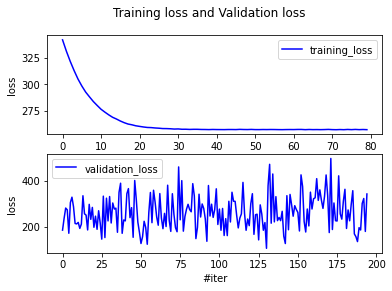

In [12]:
# Plot loss curves

%matplotlib inline
plt.clf()
plt.suptitle("Training loss and Validation loss")
plt.subplot(2, 1, 1)
plt.plot(train_epochs_loss[20:], 'b', label = 'training_loss')
plt.ylabel('loss')
plt.xlabel('#epoch')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(valid_loss, 'b', label = 'validation_loss')
plt.ylabel('loss')
plt.xlabel('#iter')
plt.legend()
#plt.savefig("loss_900epoch_down.jpg")

In [27]:
print(np.array(train_epochs_loss).shape, np.array(valid_epochs_loss).shape)
print(np.array(train_loss).shape, np.array(valid_loss).shape)

(600,) (2,)
(25800,) (26,)


## Estimation

(3900, 2, 90, 33)
(3900, 3)


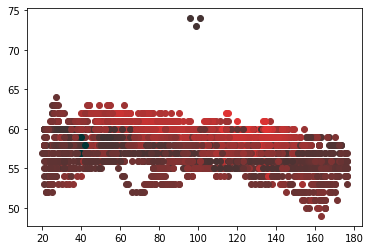

In [14]:
datadir = '../Dataset/make01/'
gt_x = datadir + 'x.npy'
gt_y = datadir + 'y.npy'
sample_x = np.load(gt_x)
sample_y = np.load(gt_y)
print(sample_x.shape)
print(sample_y.shape)
for i in range(len(sample_y)):
    plt.scatter(sample_y[i][0], sample_y[i][1], color=(sample_y[i][2]/4000, 0.2, 0.2))
plt.show()

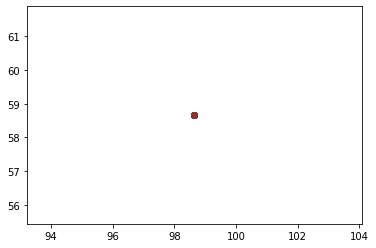

In [15]:
%matplotlib inline
for i in range(len(sample_x)):
    data = torch.tensor(sample_x[i], dtype=torch.float32, device=args.device)
    predictions = model(data)
    pred = predictions.cpu().detach().numpy()[0]
    plt.scatter(pred[0], pred[1], color=(pred[2]/4000, 0.2, 0.2))
plt.show()